In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import h5py
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

def load_data(path):
    """
    Load h5 file and convert it to a pandas DataFrame.

    Parameters:
        path (str): Path to the .mat dataset file.
    Returns:
        pd.DataFrame: DataFrame containing the dataset.
    """

    with h5py.File(path, "r") as f:
        key = list(f.keys())[0]
        raw = f[key][:]  # uint8 array

    # Convert to text
    text = raw.tobytes().decode("utf-8")

    # Load as json
    data_json = json.loads(text)

    # Extract relevant fields
    data = {
        "Time": data_json["Time"],
        "I": data_json["I"],
        "U": data_json["U"],
        "Line": data_json["Line"],
        "Capacity": data_json["Ah"]
    }

    # Convert to DataFrame
    df = pd.DataFrame(data)   

    return df 

def process_states(data):
    """
    Process the battery dataset and assign operational states based on the 'Line' column.

    Parameters:
        path (str): Path to the .mat dataset file.

    Returns:
        dict: Dataset including the computed 'status' column.
    """

    # Define operational states based on 'Line' value ranges
    data["status"] = np.where(data["Line"] <= 13, "Rest", "")
    data["status"] = np.where((data["Line"] > 13) & (data["Line"] < 15), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 14) & (data["Line"] < 16), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 15) & (data["Line"] < 17), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 16) & (data["Line"] < 19), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 19) & (data["Line"] < 21), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 20) & (data["Line"] < 22), "CV Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 21) & (data["Line"] < 23), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 22) & (data["Line"] < 24), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 23) & (data["Line"] < 26), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 26) & (data["Line"] < 28), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 27) & (data["Line"] < 33), "CV Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 32) & (data["Line"] < 34), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 33) & (data["Line"] < 35), "CC Charge", data["status"])
    data["status"] = np.where((data["Line"] > 34) & (data["Line"] < 36), "CV Charge", data["status"])
    data["status"] = np.where((data["Line"] > 35) & (data["Line"] < 37), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 37) & (data["Line"] < 42), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 41) & (data["Line"] < 43), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 42) & (data["Line"] < 44), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 43) & (data["Line"] < 49), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 48) & (data["Line"] < 50), "CC Discharge", data["status"])
    data["status"] = np.where((data["Line"] > 49) & (data["Line"] < 51), "Rest", data["status"])
    data["status"] = np.where((data["Line"] > 50) & (data["Line"] < 56), "Current Pulses", data["status"])
    data["status"] = np.where((data["Line"] > 55), "Other", data["status"])
    return data

def calculate_metrics(data):
    """
    Analyze and compute metrics for each continuous period of a specific battery status.
    Parameters:
        data (dict): cell data 
    Returns:
        pd.DataFrame: DataFrame containing metrics for each status period.
    """

    # Identify changes in status to segment the data
    data["status_change"] = (data["status"] != data["status"].shift()).cumsum()

    # Group by status change segments
    grouped = data.groupby("status_change")

    results = []
    for _, g in grouped:

        subset = g.iloc[3:-3]

        if subset.empty or subset["status"].isna().all():
            continue

        status = subset["status"].iloc[0]
        start_time = subset["Time"].iloc[0]
        end_time = subset["Time"].iloc[-1]
        duration = end_time - start_time

        avg_current = subset["I"].mean()
        std_current = subset["I"].std()

        avg_tension = subset["U"].mean()
        std_tension = subset["U"].std()

        results.append({
            "status": status,
            "start_time": start_time,
            "end_time": end_time,
            "duration": duration,
            "avg_current": avg_current,
            "std_current": std_current,
            "avg_tension": avg_tension,
            "std_tension": std_tension
        })

    return pd.DataFrame(results)

def create_df():
    src = "../../../../../../media/mods-pred/Datasets/Data_Munich_h5"
    checkups_paths = []

    # Get all checkup paths
    for cell in sorted(os.listdir(src)):
        cell_path = os.path.join(src, cell)
        for file in sorted(os.listdir(cell_path)):
            if "CHECKUP" in file:
                checkups_paths.append(os.path.join(cell_path, file))

    all_cycles = [] # Contains the features of each cycle

    for checkup in checkups_paths:
        # Load checkup data
        df = load_data(checkup)
        
        # Process states and create metrics table
        df = process_states(df)
        results = calculate_metrics(df)

        # Separate features by group
        features = {}
        for status_name, group in results.groupby("status"):
            features[f"{status_name}_avg_current"] = group["avg_current"].mean()
            features[f"{status_name}_std_current"] = group["std_current"].mean()
            features[f"{status_name}_avg_tension"] = group["avg_tension"].mean()
            features[f"{status_name}_std_tension"] = group["std_tension"].mean()
            #features[f"{status_name}_duration"] = group["duration"].sum()

        # Calculate real SoH (nominal capacity = 2.5 Ah)
        features["SoH"] = max(df["Capacity"]) * 100 / 2.5

        # Store cell id
        features["cell_id"] = os.path.basename(os.path.dirname(checkup))

        # Add features to all_cycles array
        all_cycles.append(features)

    # Create final df
    df = pd.DataFrame(all_cycles).fillna(0)

    return df

def RF_full_plot(y_test, y_pred_rf):

    # RF results plot
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_rf, color='green', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("Real SoH (%)")
    plt.ylabel("Predicted SoH (%)")
    plt.title("Random Forest")
    plt.grid(True)
    plt.tight_layout()
    plt.show() 

def RFmodel(X_train, y_train, X_test, y_test):

    # Applying Random Forest function
    rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    # Results
    print("Random Forest")
    print("R²:", r2_score(y_test, y_pred_rf))
    print("MAE:", mean_absolute_error(y_test, y_pred_rf))
    importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
    importances.sort_values(ascending=False).to_csv("important_features2.txt", sep="\t", header=False)

    # Plots
    RF_full_plot(y_test, y_pred_rf)

In [10]:
# Creates the final data frame
df = create_df()

Random Forest
R²: 0.9721501648930706
MAE: 1.4227565476249016


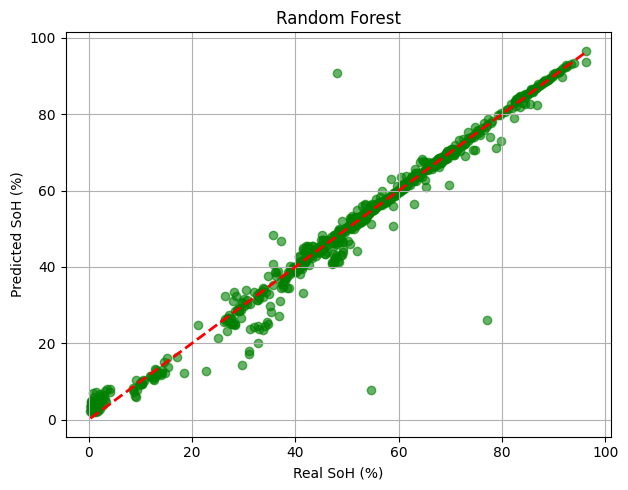

In [11]:
# Train size: 80%; Test size: 20%
cells = df["cell_id"].unique()
train_cells, test_cells = train_test_split(cells, test_size=0.2, random_state=42)

# Creating X and Y test/train 
train_df = df[df["cell_id"].isin(train_cells)]
test_df = df[df["cell_id"].isin(test_cells)]
X_train = train_df.drop(columns=["SoH", "cell_id"])
y_train = train_df["SoH"]
X_test = test_df.drop(columns=["SoH", "cell_id"])
y_test = test_df["SoH"]

# Train model and show results
RFmodel(X_train, y_train, X_test, y_test)